In [12]:
setwd('C:/Users/Mhuth/Desktop/PCRPVA') #only for local computations
files <- c('PCA_PropVar', 'PCA', 'PCR_cv', 'PCR_predict', 'PCR', 'random_discreteVariables', 'random_VCV') #names of files to read
for (i in 1:length(files)) { #loop to read all files
    source(paste('R/', files[i], '.R', sep = '')) 
}

#install.packages('dagitty')
library(dagitty)

---
# 3. Model
---

## 3.1 Baseline Equation of Wages

To model the real hourly wages of an individual $i$ I follow the baseline equation of Card (2001), that models the logarithmic wage as quadratic function of schooling. I extend it by adding work experience as a second order polynomial, the number of siblings and the years of parent's education. The additional covariates are used in Blundell et al (2005) for a different model that evaluates the effects of education on earnings. I decided to use a model in style of Card (2001), since the model reported in Blundell et al (2005) included many unobservable terms, for which I could not find good proxy variables. However, the latter paper served as a good resource to find reasonable moments of the variables for my simulation study. The notation is the following

- $Y_i:=$ wage at age 33
- $a:=$ constant term for all individuals
- $a_i:=$ individual's ability  
- $s_i :=$ individual's years of schooling
- $w_i := $ individual's work experience
- $n_i:= $ number of Siblings
- $e_i:= $ parent's years of education
- $\varepsilon_i:= $ normal distributed error and uncorrelated with the other variables.
- $T_{i,g,c}:= $ individual's test score in grade $g$ of subject $c$   

\begin{align}
\ln (Y_i) = a + a_i + \beta_1 s_i  + \beta_2 w_i + \beta_3 w_i^2 + \beta_4 n_i + \beta_5 e_i + \varepsilon_i
\tag{3.1}
\end{align}

Since ability is not observable in the real world, I use math and reading test scores from the seventh and eleventh grade as a proxy variable in the analysis. Since basically all of the regressors should follow some correlation with each other, I have chosen to examine the effects of the prediction using PCA and PCR. Hence, i have omitted dummy variables like regional or gender specific effects from my analysis. Since the wage is observed at age 33 in Blundell et al (2005) for each individual, age is also omitted from the regression.

## 3.2 Data Generating Process

Setting up the data generating Process (DGP), I faced three main issues 

1. there should be a reasonable correlation structure between the variables
2. there should not be impossible values, e.g. negative count variables
3. benchmark population moments from Blundell et al (2005) should be met

My strategy was to first deterine the dependencies , then determining the respective scaling of all variables and finally determine equations to impose a structure that meets the given population moments and the dependency structure. 

### 3.2.1 Dependency Structure (Causal Graph)
The dependency structure can best be illustrated using a causal graph. Most relationships are straightforward. Parent's with high eduaction usually have fewer children (Cygan-Rehm and Maeder, 2013), ability influences test scores (Hansen et al, [2004](https://www.sciencedirect.com/science/article/pii/S0304407603002598)) and parents with education tend to have children with more schooling years (Davis-Kean and Pamela, 2005). A key assumption is that ability is random and not affected by any other variable, e.g. parent's education. (reason why this is reasonable: hard to measure ability, random seems reasonable, facilitates model a lot)

**Figure X.X - Causal Graph** 

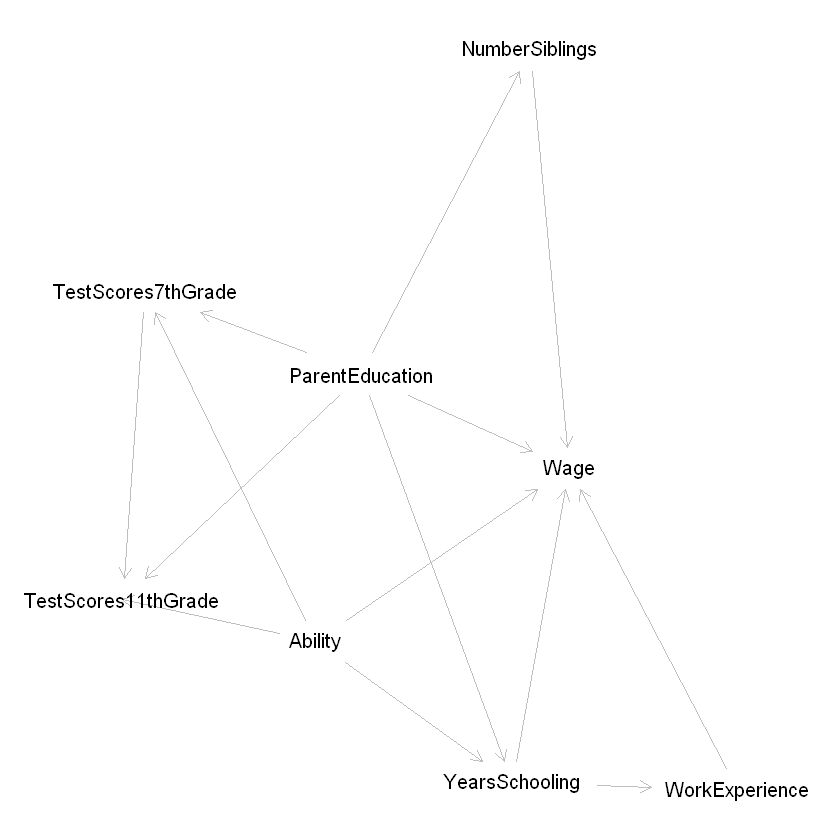

In [43]:
causal_graph <- dagitty("dag {
Ability -> TestScores7thGrade Ability Ability -> TestScores11thGrade Ability -> YearsSchooling Ability -> Wage
TestScores7thGrade -> TestScores11thGrade 
ParentEducation -> TestScores7thGrade ParentEducation -> TestScores11thGrade ParentEducation -> NumberSiblings ParentEducation -> YearsSchooling
YearsSchooling -> WorkExperience YearsSchooling -> Wage
NumberSiblings -> Wage ParentEducation -> Wage
WorkExperience -> Wage
}")
set.seed(9)
plot(graphLayout(causal_graph))

### 3.2.3 Scaling of the Variables

To have a realistic DGP set up, it is necessary that the variables have the right scaling, e.g. negative values for the count variables schooling, work experience and number of siblings and for the wage must be avoided. Moreover, test Scores should be distributed in an interval that is bounded below and above. Since there is no natural scaling for ability, I assume that ability can possibly take any real value. The scaling is therefore

**Table X.X - Scaling of the Variables**

| Variable | Scaling   |
|------|------|
|   Wages  | $\mathbb{R}_+  $|
|   Ability  | $\mathbb{R}  $|
|   Test Scores  | $[0,1]  $|
|   Schooling  | $\mathbb{N}_0  $|
|   Work Experience  | $\mathbb{N}_0  $|
|   Number of Siblings  | $\mathbb{N}_0  $|
|   Parent's Years of Education  | $\mathbb{N}_0  $|

I use the derived dependency structure and scaling to build the fundamentals for the DGP in the next subsection.

### 3.3.3 Equations to build the DGP

The causal graph given above is the fundament of my strategy to create the DGP. Every variable is dependent on each variable that points at them. Summing up this structure in general equations yields 

\begin{align}
    Y_i =& f_0(a_i, s_i, w_i, n_i, e_i)\\
    T_{i,7,c} =& f_1\left(a_i, e_i \right) \\
    T_{i,11,c} =& f_2\left(a_i, e_i, T_{i,7,c} \right)\\
    s_i =& f_3(a_i, e_i) \\
    w_i =& f_4(s_i) \\
    n_i =& f_5(e_i) \\
    \tag{3.2}
\end{align}

whereby $f_j$ is a function that models the relationship between the dependent and independent variable. Note that $f_0$ is already determined in equation *(3.1)*. The ability and parent's education are assumed to be not caused by any other variables. My aim is now to find reasonable forms for the $f_j$ such that parametrizations meet the requirements for a realistic DGP derived in the previous subsections. Thus, I first determine parent's education and ability, since they are not caused by other variables. Subsequently, I use the imposed assumptions to build the model step by step. 

**Parents' Education**

Since parent's education is not caused by the other variables and positive integer valued, I decided to draw n independent times from a Generalized Poisson distribution. The distribution yields only positive integers or zero and allows, other than the Poisson distribution, for overdispersion in the data. Following Jung and Tremayne (2010), I denote the generalized Poisson distribution for parent's education with parameters $\lambda_e \in \mathbb{R}_+$ and $\eta_e \in [0,1)$ by $GP(\lambda_e, \eta_e)$. The probability mass function is given by

\begin{align}
Prob\left(E = e\right) = \frac{\lambda(\lambda + e \eta)^{e-1} \cdot \exp{\left[-(\lambda + e \eta) \right]}}{e!},
\tag{3.3}
\end{align}

The first and second moment is given by $\text{E}(e_i) = \frac{\lambda_e}{1-\eta_e}$ and $ \text{Var}(e_i) =\frac{\lambda_e}{(1-\eta_e)^3}$. Setting $\eta_e = 0$ yields the ordinary Poisson distribution and therefore the setting allows to also use Poisson distributed random variables by adjusting $\eta$. For a full summary of the distribution I reference to Consul and Jain (1973).\
To find the parameterization that suits the first and second population moments, I use that the expected outcome of one individual equals the population mean $\mu_e$ and the variance equals the population variance $\sigma_e^2$.

\begin{align}
    \sigma_e^2 = \text{Var}(e_i) = \frac{\lambda_e}{(1-\eta_e)^3} =  \frac{\text{E}(e_i)}{(1-\eta_e)^2} = \frac{\mu_e}{(1-\eta_e)^2} \Longleftrightarrow \eta_e = 1 - \frac{\sqrt{\mu_e}}{\sigma_e} \Longrightarrow \lambda_e = \frac{\mu_e^{1.5}}{\sigma_e}
    \tag{3.4}
\end{align}

For subsequent derivations, I denote the distribution function of $e_i$ by $G_{e}$.

**Ability**

Since there is no clear scaled measure for ability and hence, I cannot match the distribution to population means, I decided to usa a normal distribution with mean zero, such that $a_i \sim \mathcal{N}\left(0, \sigma^2_{ability}\right)$. Since I will make use of this when I define the process for the years of schooling, I denote the cumulative distribution function (cdf) of $a_i$ by $\phi_a$. I chose the normal distribution to assume that most individuals have similar abilities but there are some individuals with very low or very high abilities.

**Test Scores**

To build the test scores, I use a modified version of Hansen et al (2004). They examine, inter alia, the relationship of ability on test scores. Since test scores should have an upper and a lower bound, I decided to use test scores that are distributed in the unit interval $[0,1]$. The approach in Hansen et al (2004) is to round values that exceed a certain threshold. However, this could change the population moments. Moreover, my setting allows easy extensions to any desired distribution, by regarding the uniform distributed variables as values of the cdf of a certain random variable. \
From equations *(3.2)* it follows that the test scores are a function of ability and parent's education. I decided to model for every test a continous latent process $T^*_{i, g, c}$, whereby $g \in \{7,11 \}$, $c \in \{ \text{math}, \text{reading}\}$, $i = 1, \dots, n$. The latent test scores for the 7th grad tests are defined as 

\begin{align}
T^*_{i,7,c} = \gamma_{ability} \cdot ability + \varepsilon_{i,7,c} ,
\tag{3.5}
\end{align}, 

whereby I assume that  $\varepsilon_{i,7,c} \sim \mathcal{N}(0, \sigma^2)$ and uncorrelated with ability. Hence, $T^*_{i,7,c} \sim \mathcal{N}(0, \gamma_{ability}^2 \sigma^2_{ability} + \sigma^2)$ with distribution function $\phi_7$. Individuals in my model get a test score that equals the a weighted average of the distribution function value of their latent test score and the distribution function value of their parent's education.

\begin{align}
T_{i,7,c} = (1-\rho) \cdot \underbrace{\phi_7 \left( T^*_{i,7,c} \right)}_{\sim unif(0,1)} + \rho \cdot \underbrace{G_e(e_i)}_{\sim unif(0,1)},
\tag{3.6}
\end{align}

whereby $\rho \in [0,1]$ and therefore $T_{i,7,c} \sim unif(0,1)$. Note that I made use that the value of the distribution function is uniform distributed. A derivation can be found in the appendix *A.6*. \
Moving to further stages of their education, the individuals in my model write a new test and score the same latent value as in the 7th grade plus/minus a stochastic error $\varepsilon_{i,11,c} \sim \mathcal{N}(0, \sigma^2)$.

\begin{align}
T^*_{i,11,c} = T^*_{i,7,c} + \varepsilon_{i,11,c}
\tag{3.7}
\end{align}

Hence, $T^*_{i,11,c} \sim \mathcal{N}(0, \gamma_{ability}^2 \sigma^2_{ability} + 2\sigma^2)$. To obtain the test scores, I apply the same transformation as in equation *(3.6)*. Note that this transforming ensures flexibility to allow basically any distribution of grades. Making use that the cdf is uniform distributed *A.6*, it is possible to transform the test scores to any desired distribution. For a first analysis I will stick to the uniform distributed test scores to have more variation in the data.

**Number of Siblings**

To determine the structure of $f_5$, I have used a model that is similar to the ones used for integer valued count data models, see (Jung and Tremayne, 2010). Economic literature hase argued for a long time that higher educated individuals have fewer children because the demand of children increases with higher educatuion due to increasing opportunity costs (Willis, 1973; Bailey, 2010). Cygan-Rehm and Maeder (2013) found that one additional year of education reduced the number of children around 0.1. I have built a model that accounts for this by using bernoulli experiments with probability $p$ and an additional error term $W_i \sim GP(\lambda^{sib}, \eta^{sib})$. 

\begin{align}
n_i = \sum_{j = 1}^{m-e_i} B_{ij} + W_i, 
\tag{3.8}
\end{align}

$m$ is the maximum years of parent's education, $B_{ij} \sim \mathcal{B}(p)$ is Bernoulli distributed. All $B_{ij}$ and $W_i$ are independent. Note that $\sum_{j = 1}^{m-e_i} B_{ij} | e_i \sim Bin(m-e_i, p)$. Since $\text{E}(n_i|e_i + 1) - \text{E}(n_i| e_i) = (m - e_i - 1)p - (m - e_i)p = - p$, the structure is set up such that one additional year decreases the expected number of children by $p$.\
To meet the requirements of the population means the respective parameters $\lambda^{sib}, \eta^{sib}$ must be set to

\begin{align}
\eta^{sib} =&  1 - \left(\frac{\mu_n - (m - \mu_{e}) \cdot p}{\sigma^2_n - (m-\mu_e)\cdot p \cdot (1-p) + p^2 \cdot \sigma^2_s}\right)^{0.5}\\
\lambda^{sib} =& [\mu_n - (m - \mu_{e}) \cdot p] \cdot (1-\eta^{sib}),
\tag{3.9}
\end{align}

whereby $\mu_n$ and $\sigma^2_n$ are the first and second moment of the number of siblings. A detailed derivation is given in the appendix. 

**Years of schooling**

The challenge is to find asuitbale form for $f_3$. The structure I impose is similar to the one for the number of siblings. However, in addition to the parent's years of education, the years of schooling are also caused by an individual's ability. The error in my model is dependent on an individuals ability, such that $W^{sch}_i |a_i \sim GP(\lambda_i^\text{sch}, \eta^{sch})$ and $\lambda_i = k \cdot \phi_a(a_i)$, whereby $k \in \mathbb{R}$. Note that using that the a cdf is uniform distributed, it follows that $\lambda_i^{sch} \sim unif[0, k]$. It is well-known that $\text{E}(\lambda_i^{sch}) = \frac{k}{2}$ and $\text{Var}(\lambda_i^{sch}) = \frac{k^2}{12}$. The years of schooling are set up as follows

\begin{align}
    s_i = \sum_{j = 1}^{e_i} B_{i,j}^{sch} + W^{sch}_i,
    \tag{3.10}
\end{align}

with $B_{i,j}^{sch} \sim \mathcal{B}(q)$. To meet the population moments $\mu_s$ and $\sigma^2_{s}$, it is necessary to find a suitable parametrization for $k$ and $\eta^{sch}$. They are given by

\begin{align}
k =& \pm \frac{2(\mu_{s} - \mu_{e}  \cdot q) }{\left[\sigma^2_{s} - \mu_{e} \cdot q \cdot (1-q) - \sigma_{e}^2 \cdot q - \frac{1}{3} (\mu_{s} - \mu_{e} \cdot q)^2 \right]^{0.5}} \\
\eta =& 1 -  \frac{k}{2(\mu_{s} - \mu_{e}  \cdot q)} 
\tag{3.11}
\end{align}

$k$  is chosen such that $k >0$. A full derivation for both parameters can be found in the appendix *(A.8)*.

**Work experience**

The work experience is determined by imposing only a linear structure for $f_4$ such that

\begin{align}
w_i = age_i - 6 - s_i - gap_i,
\end{align}

whereby gap is da random variable that takes the values $(0,1,2,3)$ with probabilities $p_{0},p_{1}, p_{2}, p_{3}$. to account for gap years.
*Find why minus 6 in blundell paper*. In analysis age is set to 6.

**Wages**

As given in equation *(3.1)*, the wages are a function of all the mentioned covariates but the test scores. To ease readability, I restate the equation and write it in compact vector notation.

\begin{align}
\ln (Y_i) = a + a_i + \beta_1 s_i +  \beta_2 w_i + \beta_3 w_i^2 + \beta_4 n_i + \beta_5 e_i + \varepsilon_i = a + X_i^T \beta + \varepsilon_i,
\tag{3.1}
\end{align}

whereby $\varepsilon_i \sim \mathcal{N}\left(0, \sigma_{\varepsilon}^2 \right)$ is an error term uncorrelated with the other variables on the right-hand side of the equation. I denote the expected value of the logarithmic hourly wage by $\mu_Y$, its variance by $\sigma_Y$ and by $\mu_x$ the vector of the means the variables in X. $\Sigma_x$ is the respective VCV matrix. The challenge is now to set the $\beta$ parameters such that the population moments are met. Additionaly, it might be desirable to set upper and lower bounds $\beta_j^{max}, \beta_j^{min}$ for each $\beta_j$. Using the weighted squarred deviation from the true population moments as objective function, the optimization problem at hand is 

\begin{align}
\beta = \arg \min_{b \in \mathbb{R}^{|\beta|}}& \quad  \tau \cdot \left[\mu_Y - a - \mu_x b \right]^2 + (1-\tau)\left[\sigma_Y^2 - b^T \Sigma_x b - \sigma^2_{\varepsilon} \right]^{2 \cdot \frac{1}{2}} \\
\textrm{s.t.}& \quad \beta^{min} \leq b \leq \beta^{max}
\end{align}


ein halb in arg min da variance quadriert wird -> zu absolute value ändern